In [1]:
import torch
import kaggle
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from models.CNN_SE_model import CNN_SE
from models.CNN_model import CNN
from copy import deepcopy


In [2]:
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files(dataset="seryouxblaster764/fgvc-aircraft", path="data/aircraft", unzip=True)
# kaggle.api.dataset_download_files(dataset="gpiosenka/100-bird-species", path="data/birds", unzip=True)

In [3]:
data_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

IMAGE_FOLDER = 'example_images'
# IMAGE_FOLDER = 'images'
dataset = ImageFolder(root=f'./preprocessed-data/{IMAGE_FOLDER}', transform=data_transforms)
print(len(dataset), dataset.classes)
num_of_classes = len(dataset.classes)

202 ['aircraft', 'birds']


In [4]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
device = 'cpu'

In [5]:
if device == 'cuda':
    model_cnn = CNN(num_of_classes).to(device)
    model_cnn_se = CNN_SE(num_of_classes).to(device)
else:
    model_cnn = CNN(num_of_classes)
    model_cnn_se = CNN_SE(num_of_classes)


criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
optimizer_cnn_se = optim.Adam(model_cnn_se.parameters(), lr=0.001)

best_cnn_acc = -1
best_cnn_se_acc = -1
best_cnn = None
best_cnn_se = None
cnn_acc_record = {'train': [], 'val': []}
cnn_se_acc_record = {'train': [], 'val': []}

In [6]:
def train(epoch):
    model_cnn.train()
    model_cnn_se.train()
    correct_cnn = 0
    correct_cnn_se = 0
    total_ct = 0
    for data in train_loader:
        x, y = data
        optimizer_cnn.zero_grad()
        optimizer_cnn_se.zero_grad()

        y_hat_cnn = model_cnn(x)
        y_hat_cnn_se = model_cnn_se(x)

        loss_cnn = criterion(y_hat_cnn, y)
        loss_cnn_se = criterion(y_hat_cnn_se, y)

        correct_cnn += (torch.max(y_hat_cnn.data, 1)[1] == y).float().sum().item()
        correct_cnn_se += (torch.max(y_hat_cnn_se.data, 1)[1] == y).float().sum().item()
        total_ct += y.size(0)

        loss_cnn.backward()
        loss_cnn_se.backward()

        optimizer_cnn.step()
        optimizer_cnn_se.step()

        # print(f"Epoch: {epoch}, CNN loss: {loss_cnn.item()}, CNN-SE loss: {loss_cnn_se.item()}")
        
    cnn_acc = correct_cnn / total_ct
    cnn_se_acc = correct_cnn_se / total_ct

    cnn_acc_record['train'].append(cnn_acc)
    cnn_se_acc_record['train'].append(cnn_se_acc)

    print(f'epoch: {epoch} training accuracy| CNN: {round(cnn_acc, 5)} CNN-SE: {round(cnn_se_acc, 5)}')

In [7]:
def validation(epoch, best_acc, best_model):
    model_cnn.eval()
    model_cnn_se.eval()
    correct_cnn = 0
    correct_cnn_se = 0
    total_ct = 0
    with torch.no_grad():
        for data in val_loader:
            x, y = data
            y_hat_cnn = model_cnn(x)
            y_hat_cnn_se = model_cnn_se(x)
            correct_cnn += (torch.max(y_hat_cnn.data, 1)[1] == y).float().sum().item()
            correct_cnn_se += (torch.max(y_hat_cnn_se.data, 1)[1] == y).float().sum().item()
            total_ct += y.size(0)

    cnn_acc = correct_cnn / total_ct
    cnn_se_acc = correct_cnn_se / total_ct

    cnn_acc_record['val'].append(cnn_acc)
    cnn_se_acc_record['val'].append(cnn_se_acc)

    best_cnn_acc, best_cnn_se_acc = best_acc
    best_cnn, best_cnn_se = best_model
    if cnn_acc > best_cnn_acc:
        best_cnn_acc = cnn_acc
        best_cnn = deepcopy(model_cnn.state_dict())
    
    if cnn_se_acc > best_cnn_se_acc:
        best_cnn_se_acc = cnn_se_acc
        best_cnn_se = deepcopy(model_cnn_se.state_dict())
    

    print(f'epoch: {epoch} validation accuracy| CNN: {round(cnn_acc, 5)} CNN-SE: {round(cnn_se_acc, 5)}')
    return (best_cnn_acc, best_cnn_se_acc), (best_cnn, best_cnn_se)

In [8]:
EPOCHS = 20
for epoch in range(EPOCHS):
    train(epoch)
    (best_cnn_acc, best_cnn_se_acc), (best_cnn, best_cnn_se) = validation(epoch, (best_cnn_acc, best_cnn_se_acc), (best_cnn, best_cnn_se))

epoch: 0 training accuracy| CNN: 0.70248 CNN-SE: 0.61157
epoch: 0 validation accuracy| CNN: 0.725 CNN-SE: 0.675
epoch: 1 training accuracy| CNN: 0.95041 CNN-SE: 0.95041
epoch: 1 validation accuracy| CNN: 0.925 CNN-SE: 0.875
epoch: 2 training accuracy| CNN: 0.98347 CNN-SE: 0.97521
epoch: 2 validation accuracy| CNN: 0.875 CNN-SE: 0.9
epoch: 3 training accuracy| CNN: 0.99174 CNN-SE: 0.98347
epoch: 3 validation accuracy| CNN: 0.8 CNN-SE: 0.875
epoch: 4 training accuracy| CNN: 0.98347 CNN-SE: 1.0
epoch: 4 validation accuracy| CNN: 0.8 CNN-SE: 0.9
epoch: 5 training accuracy| CNN: 1.0 CNN-SE: 1.0
epoch: 5 validation accuracy| CNN: 0.9 CNN-SE: 0.9
epoch: 6 training accuracy| CNN: 1.0 CNN-SE: 1.0
epoch: 6 validation accuracy| CNN: 0.925 CNN-SE: 0.9
epoch: 7 training accuracy| CNN: 1.0 CNN-SE: 1.0
epoch: 7 validation accuracy| CNN: 0.925 CNN-SE: 0.85
epoch: 8 training accuracy| CNN: 1.0 CNN-SE: 1.0
epoch: 8 validation accuracy| CNN: 0.875 CNN-SE: 0.85
epoch: 9 training accuracy| CNN: 1.0 CNN-SE:

In [9]:
model_cnn.load_state_dict(best_cnn)
model_cnn_se.load_state_dict(best_cnn_se)
model_cnn.eval()
model_cnn_se.eval()
correct_cnn = 0
correct_cnn_se = 0
total_ct = 0
with torch.no_grad():
    for data in test_loader:
        x, y = data
        y_hat_cnn = model_cnn(x)
        y_hat_cnn_se = model_cnn_se(x)
        correct_cnn += (torch.max(y_hat_cnn.data, 1)[1] == y).float().sum().item()
        correct_cnn_se += (torch.max(y_hat_cnn_se.data, 1)[1] == y).float().sum().item()
        total_ct += y.size(0)

cnn_acc = correct_cnn / total_ct
cnn_se_acc = correct_cnn_se / total_ct

print(f'test accuracy| CNN: {round(cnn_acc, 5)} CNN-SE: {round(cnn_se_acc, 5)}')


test accuracy| CNN: 0.97561 CNN-SE: 0.95122


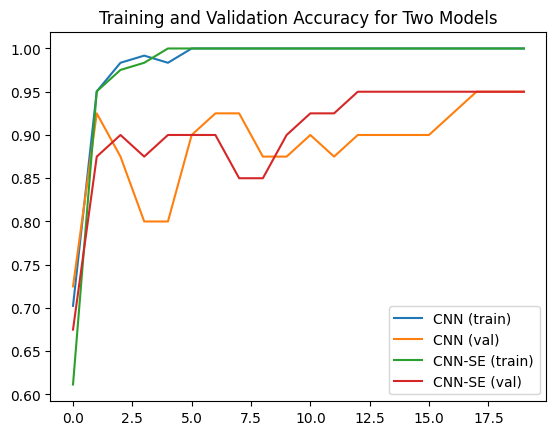

In [10]:
plt.plot(cnn_acc_record['train'], label='CNN (train)')
plt.plot(cnn_acc_record['val'], label='CNN (val)')

plt.plot(cnn_se_acc_record['train'], label='CNN-SE (train)')
plt.plot(cnn_se_acc_record['val'], label='CNN-SE (val)')

plt.title('Training and Validation Accuracy for Two Models')
plt.legend()

plt.show()
